In [31]:
import argparse
import os
import warnings
import yaml

import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.accelerators import find_usable_cuda_devices
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from nanodet.data.collate import naive_collate
from nanodet.data.dataset import build_dataset
from nanodet.evaluator import build_evaluator
from nanodet.trainer.task import TrainingTask
from torchvision.transforms import ToTensor, ToPILImage
from nanodet.util import (
    NanoDetLightningLogger,
    cfg,
    convert_old_model,
    env_utils,
    load_config,
    load_model_weight,
    mkdir,
)
import random
from torch.utils.data import Subset
from IPython.display import Image
from IPython.display import display

#Set logger and seed
logger = NanoDetLightningLogger('test')
pl.seed_everything(1234)

Global seed set to 1234


1234

In [2]:
#Classes to handle the datasets in the replay scenario

class ReplayDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __getitem__(self, index):
        x1, y1 = self.dataset1[index]
        random_index = random.randint(0, len(self.dataset2) - 1)
        x2, y2 = self.dataset2[random_index]  # Use modulo to wrap around the second dataset
        return x1, y1, x2, y2 # Maybe return (x1, x2), (y1, y2)

    def __len__(self):
        return len(self.dataset1)
    
class StandardBufferDataset(Dataset):
    def __init__(self, dataset_n, buffer_size=250):
        self.buffer_size = buffer_size
        #At initialization, take random samples of the task 0 dataset to fill the buffer
        buffer_indices = random.sample(range(len(dataset_n)), self.buffer_size)
        self.buffer_dataset = Subset(dataset_n, buffer_indices)

    def __getitem__(self, index):
        #Just return a buffer item at the index
        return self.buffer_dataset[index]

    def __len__(self):
        #Return the buffer size
        return self.buffer_size

    def update_buffer(self, dataset_np1):
        #Take a random subset of the old buffer
        update_buffare_indices = random.sample(range(self.buffer_size), self.buffer_size/2)
        subset_n = Subset(self.buffer_dataset, new_rand_indices)

        #Take a random subset of the new task dataset
        new_rand_indices = random.sample(range(len(dataset_np1)), self.buffer_size/2)
        subset_np1 = Subset(dataset_np1, new_rand_indices)

        #Concate the two subsets to form the new buffer
        self.buffer_dataset = torch.utils.data.ConcatDataset([subset_n, subset_np1])

In [3]:
#Function to create the task configuration file required for training
def create_exp_cfg(yml_path, task):
    all_names = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
    #Load the YAML file
    with open(yml_path, 'r') as file:
        temp_cfg = yaml.safe_load(file)
    #Save dir of the model
    temp_cfg['save_dir'] = 'models/task' + str(task)
    #If base task, training and testing classes are the same
    if task == 0:
        temp_cfg['data']['train']['class_names'] = all_names[:15]
        temp_cfg['data']['val']['class_names'] = all_names[:15]
        temp_cfg['model']['arch']['head']['num_classes'] = 20 #15
        #temp_cfg['model']['arch']['aux_head']['num_classes'] = 20 #15
    #Else, training only on task specific class, and testing on all classes
    else:
        temp_cfg['data']['train']['class_names'] = [all_names[14+task]]
        temp_cfg['data']['val']['class_names'] = all_names[:15+task]
        temp_cfg['model']['arch']['head']['num_classes'] = 20#15+task
        #temp_cfg['model']['arch']['aux_head']['num_classes'] = 20#15+task
        temp_cfg['schedule']['load_model'] = 'models/task' + str(task-1) + '/model_best/model_best.ckpt'
        
    temp_cfg_name = 'cfg/task' + str(task) + '.yml'
    print(temp_cfg_name)
    #Save the new configuration file
    with open(temp_cfg_name, 'w') as file:
        yaml.safe_dump(temp_cfg, file)

In [35]:
task = 0
create_exp_cfg('cfg/VOC.yml', task)
load_config(cfg, 'cfg/task' + str(task) + '.yml')
#Build datasets and dataloaders based on the task configuration file
train_dataset = build_dataset(cfg.data.train, "train")
#val_dataset = build_dataset(cfg.data.val, "test")
if task == 0:
    buffer_dataset = StandardBufferDataset(train_dataset)
else:
    buffer_dataset = buffer_dataset.update_buffer(train_dataset)

train_dataloader = torch.utils.data.DataLoader(
    buffer_dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    collate_fn=naive_collate,
    drop_last=True,
)

cfg/task0.yml
creating index...
index created!


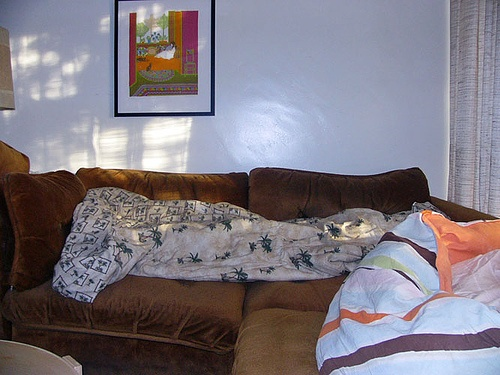

[]


In [36]:
all_names = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
random_index = random.randint(0, 249)
gt_labels = train_dataloader.dataset[random_index].get('gt_labels')
img = train_dataloader.dataset[random_index].get('img_info').get('file_name')
root = 'C:/Dataset/VOC/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'
root_img = os.path.join(root, img)
im_display = Image(filename=root_img)
display(im_display)
selected_elements = [all_names[i] for i in gt_labels]
print(selected_elements)

In [59]:
task = 1
create_exp_cfg('cfg/VOC.yml', task)
load_config(cfg, 'cfg/task' + str(task) + '.yml')
#Build datasets and dataloaders based on the task configuration file
train_dataset = build_dataset(cfg.data.train, "train")

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    collate_fn=naive_collate,
    drop_last=True,
)



cfg/task1.yml
creating index...
index created!


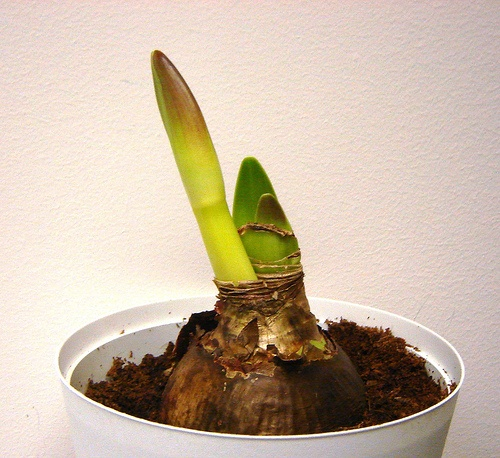

['aeroplane']


In [125]:
all_names = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
random_index = random.randint(0, 249)
gt_labels = train_dataloader.dataset[random_index].get('gt_labels')
img = train_dataloader.dataset[random_index].get('img_info').get('file_name')
root = 'C:/Dataset/VOC/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'
root_img = os.path.join(root, img)
im_display = Image(filename=root_img)
display(im_display)
selected_elements = [all_names[i] for i in gt_labels]
print(selected_elements)

In [ ]:
# Assuming train_dataset and other_dataset are your two datasets
combined_dataset = CombinedDataset(train_dataset, other_dataset)

# Create a DataLoader with batch size of 32
dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

# Now, each batch from dataloader will have 16 samples from train_dataset and 16 samples from other_dataset
for i, (x1, y1, x2, y2) in enumerate(dataloader):
    # x1, y1: data and labels from train_dataset
    # x2, y2: data and labels from other_dataset
    pass

In [7]:
#Learning stream
#task 0: train on first 15 classes, test on 15 classes
#task 1: train on class n°16, test on 16 classes
#task 2: train on class n°17, test on 17 classes
#task 3: train on class n°18, test on 18 classes
#task 4: train on class n°19, test on 19 classes
#task 5: train on class n°20, test on 20 classes
for task in range (0, 5):
    logger = NanoDetLightningLogger('run_logs/task'+str(task))
    logger.info("Starting task" + str(task))
    logger.info("Setting up data...")
    #Create the task configuration file based on the task number and load the configuration
    create_exp_cfg('cfg/VOC.yml', task)
    load_config(cfg, 'cfg/task' + str(task) + '.yml')
    #Build datasets and dataloaders based on the task configuration file
    train_dataset = build_dataset(cfg.data.train, "train")
    val_dataset = build_dataset(cfg.data.val, "test")
    evaluator = build_evaluator(cfg.evaluator, val_dataset)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=cfg.device.batchsize_per_gpu,
        shuffle=True,
        num_workers=cfg.device.workers_per_gpu,
        pin_memory=True,
        collate_fn=naive_collate,
        drop_last=True,
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=cfg.device.batchsize_per_gpu,
        shuffle=False,
        num_workers=cfg.device.workers_per_gpu,
        pin_memory=True,
        collate_fn=naive_collate,
        drop_last=False,
    )
    #Create the model based on the task configuration file
    logger.info("Creating model...")
    task = TrainingTask(cfg, evaluator)
    #Load the model weights if task is not 0
    if "load_model" in cfg.schedule:
        ckpt = torch.load(cfg.schedule.load_model)
        if "pytorch-lightning_version" not in ckpt:
            warnings.warn(
                "Warning! Old .pth checkpoint is deprecated. "
                "Convert the checkpoint with tools/convert_old_checkpoint.py "
            )
            ckpt = convert_old_model(ckpt)
        load_model_weight(task.model, ckpt, logger)
        logger.info("Loaded model weight from {}".format(cfg.schedule.load_model))
    model_resume_path = (
        os.path.join(cfg.save_dir, "model_last.ckpt")
        if "resume" in cfg.schedule
        else None
    )
    #Set the device to GPU if available
    if cfg.device.gpu_ids == -1:
        logger.info("Using CPU training")
        accelerator, devices, strategy, precision = (
            "cpu",
            None,
            None,
            cfg.device.precision,
        )
    else:
        accelerator, devices, strategy, precision = (
            "gpu",
            cfg.device.gpu_ids,
            None,
            cfg.device.precision,
        )

    if devices and len(devices) > 1:
        strategy = "ddp"
        env_utils.set_multi_processing(distributed=True)

    trainer = pl.Trainer(
        default_root_dir=cfg.save_dir,
        max_epochs=cfg.schedule.total_epochs,
        check_val_every_n_epoch=cfg.schedule.val_intervals,
        accelerator=accelerator,
        devices=[0],
        log_every_n_steps=cfg.log.interval,
        num_sanity_val_steps=0,
        callbacks=[TQDMProgressBar(refresh_rate=0)],
        logger=logger,
        benchmark=cfg.get("cudnn_benchmark", True),
        gradient_clip_val=cfg.get("grad_clip", 0.0),
        strategy=strategy,
        precision=precision,
    )
    trainer.fit(task, train_dataloader, val_dataloader, ckpt_path=model_resume_path)

[NanoDet][02-05 17:00:51]INFO:Starting task0
[NanoDet][02-05 17:00:51]INFO:Starting task0
[NanoDet][02-05 17:00:51]INFO:Starting task0
[NanoDet][02-05 17:00:51]INFO:Starting task0
[NanoDet][02-05 17:00:51]INFO:Starting task0
INFO:NanoDet:Starting task0
[NanoDet][02-05 17:00:51]INFO:Setting up data...
[NanoDet][02-05 17:00:51]INFO:Setting up data...
[NanoDet][02-05 17:00:51]INFO:Setting up data...
[NanoDet][02-05 17:00:51]INFO:Setting up data...
[NanoDet][02-05 17:00:51]INFO:Setting up data...
INFO:NanoDet:Setting up data...


cfg/task0.yml


creating index...
index created!


[NanoDet][02-05 17:00:52]INFO:Creating model...
[NanoDet][02-05 17:00:52]INFO:Creating model...
[NanoDet][02-05 17:00:52]INFO:Creating model...
[NanoDet][02-05 17:00:52]INFO:Creating model...
[NanoDet][02-05 17:00:52]INFO:Creating model...
INFO:NanoDet:Creating model...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


creating index...
index created!
model size is  1.0x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth
Finish initialize NanoDet-Plus Head.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type        | Params
--------------------------------------
0 | model | NanoDetPlus | 1.2 M 
--------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.699     Total estimated model params size (MB)
/home/pasti/anaconda3/envs/nanodet/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[NanoDet][02-05 17:00:55]INFO:Train|Epoch1/100|Iter0(1/78)| mem:4.34G| lr:1.00e-07| loss_qfl:0.7161| loss_bbox:1.0482| loss_dfl:0.5199| 
[NanoDet][02-05 17:00:55]INFO:Train|Epoch1/100|Iter0(1/78)| mem:4.34G| lr:1.00e-07| loss_qfl:0.7161| loss_bbox:1.0482| loss_dfl:0.5199| 
[NanoDet][02-05 17:00:55]INFO:Train|Epoch1/100|Iter0(1/78)| mem:4.34G

Loading and preparing results...
DONE (t=2.46s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.13s).
Accumulating evaluation results...


[NanoDet][02-05 17:05:30]INFO:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.215
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.258
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.576

[NanoDet

DONE (t=5.92s).


[NanoDet][02-05 17:05:31]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:05:31]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:05:31]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:05:31]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:05:31]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
INFO:NanoDet:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:05:31]INFO:Val_metrics: {'mAP': 0.21534234848034042, 'AP_50': 0.3954651408092633, 'AP_75': 0.2056239678430764, 'AP_small': 0.007166601243742006, 'AP_m': 0.061911468169523726, 'AP_l': 0.3071423814042188}
[NanoDet][02-05 17:05:31]INFO:Val_metrics: {'mAP': 0.21534234848034042, 'AP_50': 0.3954651408092633, 'AP_75': 0.2056239678430764, 'AP_small': 0.007166601243742006, 'AP_m': 0.061911468169523726, 'AP_l': 0.3071423814042188}
[NanoDet][02-05

Loading and preparing results...
DONE (t=2.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.25s).
Accumulating evaluation results...


[NanoDet][02-05 17:10:07]INFO:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.429
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.585

[NanoDet

DONE (t=5.61s).


[NanoDet][02-05 17:10:08]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:10:08]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:10:08]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:10:08]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:10:08]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
INFO:NanoDet:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:10:08]INFO:Val_metrics: {'mAP': 0.2567867358243099, 'AP_50': 0.45447055164516315, 'AP_75': 0.2524480897448554, 'AP_small': 0.00929627938811334, 'AP_m': 0.08145247242311514, 'AP_l': 0.3588006707881706}
[NanoDet][02-05 17:10:08]INFO:Val_metrics: {'mAP': 0.2567867358243099, 'AP_50': 0.45447055164516315, 'AP_75': 0.2524480897448554, 'AP_small': 0.00929627938811334, 'AP_m': 0.08145247242311514, 'AP_l': 0.3588006707881706}
[NanoDet][02-05 17:

Loading and preparing results...
DONE (t=2.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=12.80s).
Accumulating evaluation results...


[NanoDet][02-05 17:14:42]INFO:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.601

[NanoDet

DONE (t=6.44s).


[NanoDet][02-05 17:14:43]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:14:43]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:14:43]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:14:43]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:14:43]INFO:Saving model to models/task0/model_best/nanodet_model_best.pth
INFO:NanoDet:Saving model to models/task0/model_best/nanodet_model_best.pth
[NanoDet][02-05 17:14:43]INFO:Val_metrics: {'mAP': 0.2752407590962705, 'AP_50': 0.4798011816465133, 'AP_75': 0.27091718438701745, 'AP_small': 0.015237976817805678, 'AP_m': 0.09492742060825167, 'AP_l': 0.378765832707061}
[NanoDet][02-05 17:14:43]INFO:Val_metrics: {'mAP': 0.2752407590962705, 'AP_50': 0.4798011816465133, 'AP_75': 0.27091718438701745, 'AP_small': 0.015237976817805678, 'AP_m': 0.09492742060825167, 'AP_l': 0.378765832707061}
[NanoDet][02-05 17:

cfg/task1.yml


creating index...
index created!


[NanoDet][02-05 17:15:48]INFO:Creating model...
[NanoDet][02-05 17:15:48]INFO:Creating model...
[NanoDet][02-05 17:15:48]INFO:Creating model...
[NanoDet][02-05 17:15:48]INFO:Creating model...
[NanoDet][02-05 17:15:48]INFO:Creating model...
[NanoDet][02-05 17:15:48]INFO:Creating model...
INFO:NanoDet:Creating model...


creating index...
index created!
model size is  1.0x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth
Finish initialize NanoDet-Plus Head.


[NanoDet][02-05 17:15:48]INFO:Loaded model weight from models/task0/model_best/model_best.ckpt
[NanoDet][02-05 17:15:48]INFO:Loaded model weight from models/task0/model_best/model_best.ckpt
[NanoDet][02-05 17:15:48]INFO:Loaded model weight from models/task0/model_best/model_best.ckpt
[NanoDet][02-05 17:15:48]INFO:Loaded model weight from models/task0/model_best/model_best.ckpt
[NanoDet][02-05 17:15:48]INFO:Loaded model weight from models/task0/model_best/model_best.ckpt
[NanoDet][02-05 17:15:48]INFO:Loaded model weight from models/task0/model_best/model_best.ckpt
INFO:NanoDet:Loaded model weight from models/task0/model_best/model_best.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type        | Params
--------------------------------------
0 | model | NanoDetPlus | 1.2 M 
--------------------------------------
1.2 M    

cfg/task2.yml


creating index...
index created!


KeyboardInterrupt: 

In [ ]:
#PROBLEMS
#0. Model AP when training on new task goes immediately to 0
#   Looks like to model is learning pottedplant with the name "aeroplane"
#   xml dataset returns coco_dict, in cocodict need to report all the categories, FIXED
#1. Id of new class need to be consistent with id of validation dataset (sub-rroblem of 0.), FIXED
#2. Evaluator results is not printing on txt file per class AP, FIXED
#3. Weights are loaded from previous model skipping completely the heads.
#   As the model has not always the same number of classes, the model loads its weight but doesn't load the heads, this means that the model
#   immediately forgets the previous task, FIXED
# 5. TO check that the adaptation from one task to another is working, we can check that the new "adpted model" works on the previous tasks as before,This before starting to learn on the new task. -> WORKS BUT NOT PERFECTLY!!